In [1]:
import os
import numpy as np 
from keras.datasets import mnist
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score   

import bloqade 
from bloqade.ir.location import Chain, start

2025-03-26 20:58:37.936598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743022717.950264    4112 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743022717.955512    4112 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743022717.967056    4112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743022717.967084    4112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743022717.967086    4112 computation_placer.cc:177] computation placer alr

# Prepare the Dataset

In [2]:
# Download the MNIST dataset    
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
train_X, test_X = train_X / 255.0, test_X / 255.0

N_TRAIN = train_X.shape[0]
N_TEST = test_X.shape[0]

# Training dataset is 60000 images of 28x28 pixels
print(f"X_train: {train_X.shape}")
print(f"y_train: {train_y.shape}")

# Test dataset is 10000 images of 28x28 pixels
print(f"X_test: {test_X.shape}")
print(f"y_test: {test_y.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


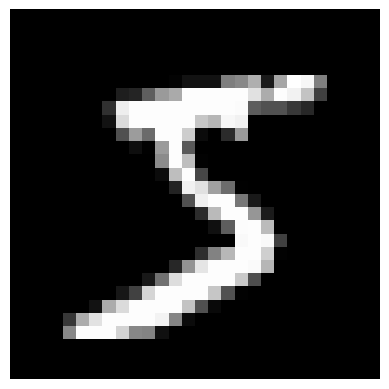

In [3]:
# Show example of image for 5
plt.imshow(train_X[0], cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

# PCA Reduction

In [4]:
# Use PCA to downsample the data into 8-dimensional vectors
dim_pca = 8

# Define PCA model
pca = PCA(n_components=dim_pca)

# The PCA requires the input to be 2D, so we make an array with 60_000 rows and 784 columns
reshaped_train_X = np.reshape(train_X, (N_TRAIN, 28*28))

# Fit the PCA model to the training data
pca.fit(reshaped_train_X)

# Transform the training data using the fitted PCA model
x_train = pca.transform(reshaped_train_X)

# Display the training set
num_train_examples = 1000
num_test_examples = 200
xs_train = x_train[
        :num_train_examples,  # Rows up to num_examples
        :               # All columns
    ]
print(
    f"""
    Training set PCA: 
    
    {xs_train[0:5, :]}
    """
)


# Same process for the test set
reshaped_test_X = np.reshape(test_X, (N_TEST, 28*28))
x_test = pca.transform(reshaped_test_X)

# Display the test set
xs_test = x_test[
            :num_test_examples,  # Rows up to num_examples
            :               # All columns
        ]
print(
    f"""
    Test set PCA:
    
    {xs_test[0:5, :]}
    """
)




    Training set PCA: 
    
    [[ 0.48601015  1.22617358  0.09613354  2.17944297 -0.10704576  0.9116717
   0.91763033  0.62666468]
 [ 3.96752304  1.15630211 -2.33858651  1.80692626 -3.24421656  0.71353148
  -0.17655089 -0.41164546]
 [-0.2033318  -1.53793393  0.73925392 -2.04318175 -1.20266952  0.00719743
  -3.36881255  1.44545833]
 [-3.13383152  2.38116556 -1.07314212 -0.41520877 -0.00726755 -2.74374391
  -1.85769884 -0.2640067 ]
 [-1.50099977 -2.86487399 -0.06413234  0.94783341  0.38494646 -0.16952834
  -0.35947686 -1.59041131]]
    

    Test set PCA:
    
    [[-1.30302419 -2.93254399  0.1680189   1.22028985 -1.9425927  -0.95048011
   1.54080817  1.84606135]
 [ 0.08116456  3.74739052  0.59888438 -1.56344059 -0.19987208  1.84491363
   1.09549373  0.90745685]
 [-3.70990929  1.68958111 -0.25951504 -1.02001031 -2.09448647 -0.34464815
  -0.09418466 -0.4312494 ]
 [ 4.83885093 -0.44290373 -0.99533214  0.38530635 -0.81798657  1.90399072
   2.72785227  0.29909493]
 [ 0.74226735 -2.80227973

#### Scale the range of principal components to a feasible range for local detuning implementation - [0, 1]  

In [5]:
# Spectral is the maximum difference between any two points in the dataset
# It is used to determine the range of the data
spectral = (np.amax(xs_train) - np.amin(xs_train))

mn = np.amin(xs_train)
xs_train = (xs_train - mn) / spectral   # The values range from 0 to 1
xs_test = (xs_test - mn) / spectral     # The values range from 0 to 1

# Build Quantum Tasks and Simulate Dynamics

We need to:  
- Define a dictionary to capture the physical parameters and readouts of the quantum system
- Define the functions that simulate quantum dynamics or build tasks that can be submitted to hardware with the input x from scaled detunings

In [6]:
atom_chain = Chain(dim_pca, lattice_spacing=10) # Linear chain of atoms with 10 microns between them

QRC_parameters={
    "atom_number": dim_pca,         # Number of atoms (dimension of the PCA space)
    "geometry_spec": atom_chain,    # Geometry of the atoms
    "encoding_scale": 9.0,          # Scaling factor for local detuning encoding
    "rabi_frequency": 6.283,        # Value of the Rabi frequency used
    "total_time": 4,                # Total maximum evolution time - 4 microseconds
    "time_steps": 8,              # Number of probe times for quantum embedding collection (number of times it's measured during evolution) - 8 in the 4 microsecond window
    "readouts": "ZZ"                 # Includes both ZZ correlators together (measures the correlations between the states of pairs of atoms in the system) with default Rydberg density as generated embeddings
}

# Define the Function to Process QRC Parameters

In [7]:
from quantum_task import build_task, process_results


def get_embeddings_emulation(xs, num_examples, n_shots=1000):
    """
        Function to get the embeddings from the quantum task

        Input: 
            xs: Training set
            num_examples: Number of examples to process
            n_shots: Number of shots for the quantum task
    
        Output:
            np.array with the embeddings of the training set
    """    
    return np.array(
        [
            process_results(
                # Dictionary with the QRC parameters
                QRC_parameters=QRC_parameters, 
                
                # Report of the quantum task
                report=build_task( # Returns job ready to be run 
                    # Dictionary with the QRC parameters
                    QRC_parameters, 
                    # Training set (iterating over every example)
                    xs[data, :]
                )
                # Take the job and run it, returning the report
                .bloqade.python().run(
                    shots=n_shots, 
                    rtol=1e-8, 
                    atol=1e-8
                )
                .report()
            )
            
            for data in range(num_examples)        
        ]
    )

# Run the Simulation

For each image, the readouts from the quantum dynamics will be a 288-dimensional vector, which has a mich higher dimenstion than the previous 8-dimension PCA.  

The results are stored in a 1000x288 matrix called train_embeddings

In [8]:
train_embeddings = get_embeddings_emulation(
    xs=xs_train, 
    num_examples=num_train_examples, 
    n_shots=1000
)

test_embeddings = get_embeddings_emulation(
    xs=xs_test, 
    num_examples=num_test_examples, 
    n_shots=1000
)

print(train_embeddings.shape)
print(test_embeddings.shape)

print(
    f"""
    Train embeddings:
    
    {train_embeddings[0:5, :]}
    """
)

print(
    f"""
    Test embeddings:
    
    {test_embeddings[0:5, :]}
    """
)

(1000, 288)
(200, 288)

    Train embeddings:
    
    [[-0.626  0.048 -0.13  ...  0.058  0.214 -0.1  ]
 [-0.126 -0.036 -0.382 ...  0.148  0.11   0.058]
 [-0.694 -0.308  0.02  ...  0.084  0.274  0.13 ]
 [-0.746  0.126 -0.246 ...  0.156  0.162  0.13 ]
 [-0.744 -0.432 -0.096 ...  0.154  0.202  0.06 ]]
    

    Test embeddings:
    
    [[-0.69  -0.428 -0.096 ...  0.14   0.302  0.19 ]
 [-0.698  0.294 -0.072 ...  0.02   0.104  0.032]
 [-0.744  0.078 -0.16  ...  0.238  0.302  0.212]
 [ 0.08  -0.198 -0.236 ...  0.234 -0.03  -0.304]
 [-0.554 -0.418  0.024 ...  0.19   0.322  0.208]]
    


# Train Neural Network to Evaluate Performance

We are going to train a classical neural network without hidden layers (a linear classificer with softmax output function), using quantum measurements stored in embeddings as the input.

For comparison, we will also train a neural network without hidden layers directly using PCA feature vectors without the quantum reservoir processing, as well as a simple neural network with two hidden layers for comparison.

In [9]:
import tensorflow as tf


# 1) Linear classifier applied to PCA features

# Build the linear model 
model = tf.keras.Sequential(
    [
    tf.keras.layers.Dense(10) # 10 output neurons (10 classes)
    ]
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fitting to training data
model.fit(
    x=xs_train[:num_train_examples],
    y=train_y[:num_train_examples],
    epochs=1000,
    batch_size=100, 
    verbose=0 
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(
    x=xs_test, 
    y=test_y[:num_test_examples], 
    verbose=0
)

print(f"PCA Linear test accuracy: {100*round(test_acc, 2)}%")

I0000 00:00:1743023517.448751    4112 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4088 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1743023517.960558    7090 service.cc:152] XLA service 0x7f68f0006720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743023517.960576    7090 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-03-26 21:11:57.970125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743023518.009472    7090 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1743023518.358252    7090 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


PCA Linear test accuracy: 68.0%


In [10]:
# 2) Classical neural network with two hidden layers

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(50, activation='relu'),   # 50 neurons in the hidden layer
        tf.keras.layers.Dense(50, activation='relu'),   # 50 neurons in the hidden layer 
        tf.keras.layers.Dense(10)                       # 10 output neurons (10 classes)
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    x=xs_train,
    y=train_y[:num_train_examples],
    epochs=1000,
    batch_size=100, 
    verbose=0 
)

test_loss, test_acc = model.evaluate(
    x=xs_test, 
    y=test_y[:num_test_examples], 
    verbose=0
)

print(f"4-Layer NN test accuracy: {100*round(test_acc, 2)}%")

4-Layer NN test accuracy: 80.0%


In [11]:
# 3) Linear classifier on quantum embeddings from the QRC
# We include regularization and tune epsilon parameter to better control training from QRC embeddings generated on finite number of samples

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            10, 
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.0001) # Regularization to avoid overfitting  
        )
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.0002), # Epsilon parameter to better control training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    x=train_embeddings,
    y=train_y[:num_train_examples],
    epochs=2000,
    batch_size=100, 
    verbose=0 
)

test_loss, test_acc = model.evaluate(
    x=test_embeddings, 
    y=test_y[:num_test_examples], 
    verbose=0
)

print(f"QRC test accuracy: {100*round(test_acc, 2)}%")

QRC test accuracy: 82.0%


We also have an implementation of the same process as before but with a SVC

In [15]:
# Just Linear PCA SVM
svm = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm.fit(xs_train, train_y[:num_train_examples])
y_pred = svm.predict(xs_test)
accuracy = accuracy_score(test_y[:num_test_examples], y_pred)
print(f"Linear PCA SVM test accuracy: {100*round(accuracy, 2)}%")

# PCA SVM with RBF kernel
svm = SVC(C=8.)
svm.fit(xs_train, train_y[:num_train_examples])
y_pred = svm.predict(xs_test)
accuracy=svm.score(xs_test, test_y[:num_test_examples])
print('SVC test accuracy (rbf kernel):', 100*round(accuracy, 2), "%")

# Linear QRC SVM
svm = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm.fit(train_embeddings, train_y[:num_train_examples])
y_pred = svm.predict(test_embeddings)
accuracy = accuracy_score(test_y[:num_test_examples], y_pred)
print(f"Linear QRC SVM test accuracy: {100*round(accuracy, 2)}%")


/home/nuno/python_envs/quAI/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear PCA SVM test accuracy: 70.0%
SVC test accuracy (rbf kernel): 89.0 %
Linear QRC SVM test accuracy: 80.0%


/home/nuno/python_envs/quAI/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
